## 1. 随机数生成

### 1.1 均匀分布随机数生成

均匀分布随机数生成最普遍的算法为<font color=red>线性同余算法（LCG）</font>，它是一个伪随机数发生器，默认的初始种子为系统时间戳，算法递推公式如下:  

$$
X_{i+1} = (A \times X_{i} +B) \operatorname{mod} M
$$  

其中:   

- $B,M$互质
- $M$的所有质因子的积能整除$(A-1)$:比如$M$是3的倍数则$(A-1)$也是
- $A,B,X_{0}$都比$M$小
- $A,B$都是正整数

In [1]:
import matplotlib.pyplot as plt
import time
import math

In [20]:
def random(num=2000):
    M = 1000
    A = 3^4
    B = 1
    # 初始种子: 当前时间
    x_0 = time.time()
    result = [x_0]
    while len(result) < num:
        result.append((result[-1]*A+B)%M)
    result.pop(0)
    return result

[831.6124839782715, 822.2873878479004, 757.0117149353027, 300.08200454711914, 101.57403182983398, 712.0182228088379, 985.1275596618652, 896.8929176330566, 279.2504234313965, 955.7529640197754]


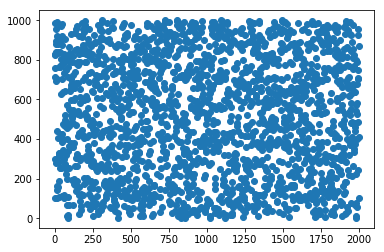

In [22]:
result = random()
print(result[:10])
xaixs = [i for i,j in enumerate(result)]
f = plt.figure(1)
p1 = plt.scatter(xaixs, result)
plt.show()

### 1.2 标准正态分布随机数生成

已知均匀分布随机数如何生成，我们可以根据其生成标准正态分布随机数，Box和Muller提出了产生$N(0,1)$随机数的简单方法:设$U_{1}$和$U_{2}$是独立同分布的$U(0,1)$变量，记  

$$
\left\{\begin{array}{l}
X_{1}=\left(-2 \ln U_{1}\right)^{1 / 2} \cos \left(2 \pi U_{2}\right) \\
X_{2}=\left(-2 \ln U_{2}\right)^{1 / 2} \cos \left(2 \pi U_{1}\right)
\end{array}\right.
$$  

则$X_{1}$和$X_{2}$相互独立且均匀服从标准正态分布。

In [23]:
import matplotlib.pyplot as plt
import time, math

In [24]:
def rnorm(num=1000):
    uniform1 = random(num)
    uniform2 = random(num)
    return [math.sqrt(-2 * math.log(i/1000, math.e)) * math.cos(2 * math.pi * j/1000) for i,j in zip(uniform1, uniform2)]

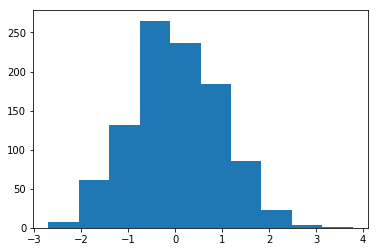

In [29]:
result = rnorm()
xaixs = [i for i,j in enumerate(result)]
f = plt.figure(1)
p2 = plt.hist(result)
plt.show()

### 1.3 其它简单分布随机数生成

对于已知pdf或cdf的分布，可以根据cdf求反函数的方法来生成该分布的随机数。因为cdf的值域为$[0,1]$，我们只需获得均匀分布随机数$U_{1}\sim U(0,1)$，即可根据cdf的反函数求得此次抽的的随机数。对于再复杂一点的分布，我们可以通过构造包络分布进行Rejection Sampling。

## 2. MCMC抽样法

### 2.1 Metropolis-Hastings法

In [77]:
import random, math
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

In [78]:
# 目标概率分布，N(3, 2)
def norm_dist_prob(theta):
    y = norm.pdf(theta, loc=3, scale=2)
    return y

In [79]:
norm_dist_prob(3)

0.19947114020071635

In [80]:
T = 10000
pi = [0 for i in range(T)]
sigma = 1
t = 0

while t < T-1:
    t += 1
    # q分布为Metropolis选择的特例1
    pi_start = norm.rvs(loc=pi[t-1], scale=sigma, size=1, random_state=None)
    # alpha = min{1, p(x')/p(x)}
    alpha = min(1, (norm_dist_prob(pi_start[0]) / norm_dist_prob(pi[t-1])))
    
    u = random.uniform(0,1)
    if u < alpha:
        pi[t] = pi_start[0]
    else:
        pi[t] = pi[t-1]

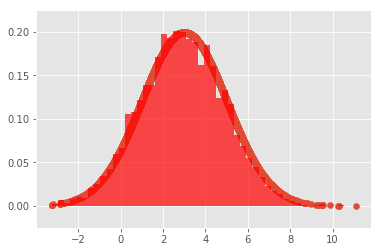

In [81]:
plt.scatter(pi[500:], norm.pdf(pi[500:], loc=3, scale=2))
num_bins = 50
plt.hist(pi[500:], num_bins, normed=1, facecolor='red', alpha=0.7)
plt.show()

### 2.2 Gibbs Sampling

假设我们要采样的是一个二维正态分布$N(\mu, \Sigma)$  

$$
\mu = (\mu_{1}, \mu_{2}) = (5, -1)  \\
\Sigma = \begin{pmatrix}
 \sigma_{1}^{2} & \rho \sigma_{1}\sigma_{2} \\
 \rho \sigma_{1}\sigma_{2} & \sigma_{2}^{2}
\end{pmatrix} = \begin{pmatrix}
 1 & 1\\
 1 & 4
\end{pmatrix}
$$

采样过程中需要的状态转移条件分布为:  

$$
\begin{array}{l}
P\left(x_{1} \mid x_{2}\right)=\text { Norm }\left(\mu_{1}+\rho \sigma_{1} / \sigma_{2}\left(x_{2}-\mu_{2}\right),\left(1-\rho^{2}\right) \sigma_{1}^{2}\right) \\
P\left(x_{2} \mid x_{1}\right)=\text { Norm }\left(\mu_{2}+\rho \sigma_{2} / \sigma_{1}\left(x_{1}-\mu_{1}\right),\left(1-\rho^{2}\right) \sigma_{2}^{2}\right)
\end{array}
$$

In [82]:
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal

In [83]:
samplesource = multivariate_normal(mean=[5, -1], cov=[[1, 1], [1, 4]])

In [84]:
def py_givenx(x, m1, m2, s1, s2):
    return (random.normalvariate(m2 + rho * s2 / s1 * (x - m1), math.sqrt((1-rho**2)*(s2**2))))

def px_giveny(y, m1, m2, s1, s2):
    return (random.normalvariate(m1 + rho * s1 / s2 * (y - m2), math.sqrt((1-rho**2)*(s1**2))))

In [87]:
N = 5000
K = 20
x_res = []
y_res = []
z_res = []
m1 = 5
m2 = -1
s1 = 1
s2 = 2

rho = 0.5
y = m2

for i in range(N):
    for j in range(K):
        x = px_giveny(y, m1, m2, s1, s2)
        y = py_givenx(x, m1, m2, s1, s2)
        z = samplesource.pdf([x, y])
        x_res.append(x)
        y_res.append(y)
        z_res.append(z)

/Users/liuqiang/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


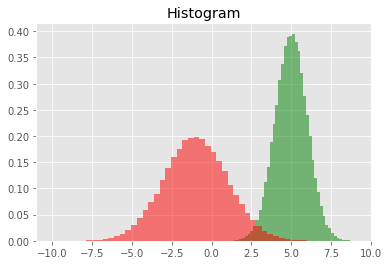

In [88]:
num_bins = 50
plt.hist(x_res, num_bins, normed=1, facecolor='green', alpha=0.5)
plt.hist(y_res, num_bins, normed=1, facecolor='red', alpha=0.5)
plt.title('Histogram')
plt.show()

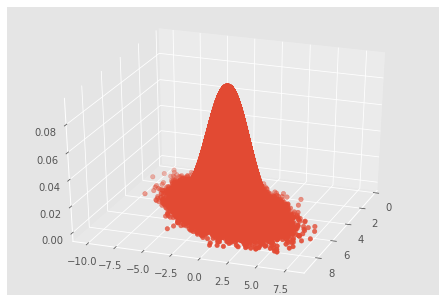

In [89]:
fig = plt.figure()
ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=30, azim=20)
ax.scatter(x_res, y_res, z_res,marker='o')
plt.show()